In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Evaluation (Metrics & DM-Test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from itertools import islice
from math import lgamma, fabs, isnan, nan, exp, log, log1p, sqrt
from typing import Sequence, Callable, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


#### **1. Data Preparation**

In [4]:
df = pd.read_csv("df_ff_factors_100325.csv")
df = df.drop(columns=["Unnamed: 0","crsp_portno"])
df = df.sort_values(by='date')
df

,crsp_fundno,date,mth_return,exp_ratio,turn_ratio,normalised_flow,mtna,gdp_to_debt_ratio,gdp_growth_rate,unm_rate,...,smb,hml,rmw,cma,rf,umd,mkt_return,excess_return,rolling_alpha_5f,shortrun_momentum
52070,21716.0,1993-05-28,-0.005886,0.0065,1.01,0.049932,124.190,63.915,3.5225,7.1,...,0.0190,-0.0342,-0.0012,-0.0104,0.0022,0.0022,NaN,-0.008086,-0.008086,NaN
52071,21716.0,1993-06-30,0.023484,0.0065,1.01,0.036697,131.211,63.915,3.5225,7.0,...,0.0013,0.0275,-0.0092,0.0121,0.0025,0.0455,NaN,0.020984,0.020984,NaN
13848,8441.0,1993-07-30,0.012705,0.0097,1.21,0.000000,511.692,64.101,3.5225,6.9,...,0.0095,0.0285,-0.0187,0.0206,0.0024,0.0316,NaN,0.010305,0.010305,NaN
52072,21716.0,1993-07-30,0.012120,0.0065,1.01,0.048386,138.698,64.101,3.5225,6.9,...,0.0095,0.0285,-0.0187,0.0206,0.0024,0.0316,NaN,0.009720,0.009720,NaN
97720,31925.0,1993-07-30,0.006554,0.0064,1.15,0.003378,635.317,64.101,3.5225,6.9,...,0.0095,0.0285,-0.0187,0.0206,0.0024,0.0316,NaN,0.004154,0.004154,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102347,36888.0,2024-10-31,-0.011755,0.0205,0.38,-0.369789,1.400,120.731,2.5427,4.1,...,-0.0568,-0.0247,0.0066,-0.0102,0.0047,0.0508,0.018446,-0.016455,-0.009595,-0.016542
176070,86513.0,2024-10-31,0.000691,0.0104,0.31,0.046618,549.600,120.731,2.5427,4.1,...,-0.0568,-0.0247,0.0066,-0.0102,0.0047,0.0508,0.018446,-0.004009,-0.001237,-0.011957
182998,95721.0,2024-10-31,-0.020548,0.0078,0.88,-0.080079,0.100,120.731,2.5427,4.1,...,-0.0568,-0.0247,0.0066,-0.0102,0.0047,0.0508,0.018446,-0.025248,0.027648,-0.015228
182760,95714.0,2024-10-31,-0.020782,0.0103,0.88,-0.001780,4.500,120.731,2.5427,4.1,...,-0.0568,-0.0247,0.0066,-0.0102,0.0047,0.0508,0.018446,-0.025482,0.027850,-0.015541


In [ ]:
# Generate Lagged Dataset
def create_lagged_dataset(dataset, lag, target_var, id):
    lagged_dataset = dataset.copy()
    columns_list = list(lagged_dataset.columns)
    data_join = {}
    for column in columns_list:
        if column == target_var:
            data_join[column] = lagged_dataset[column]
        for n in range(1,lag+1):
            data_join[F'{column}_L{n}'] = lagged_dataset.groupby(id)[column].shift(n)
    lagged_dataset = pd.concat(data_join.values(), axis=1, ignore_index = True)
    lagged_dataset.columns = data_join.keys()
    return lagged_dataset.dropna()

# Generate Stepped Dataset for Training
## Steps is the number of months ahead that we are forecasting, e.g. step=2 is 2 months ahead.
## Note step=1 results in no change to dataset, i.e. use generated lagged variables to forecast current. 
def create_stepped_dataset(dataset, step, target_var, id):
    
    shifted_dataset = dataset.copy()
    shifted_dataset['shifted_target'] = shifted_dataset.groupby(id)[target_var].shift(-step + 1)
    
    # Drop rows where the shifted target is NaN (these occur due to the shift operation)
    shifted_dataset = shifted_dataset.dropna(subset=['shifted_target'])
    
    # Separate the features (X) and the target (y)
    X = shifted_dataset.drop(columns=[target_var, 'shifted_target'])
    y = shifted_dataset[['shifted_target']]
    y = y.rename(columns={'shifted_target':target_var})
    return X, y

In [37]:
def demeaning_fund_char(dataset, id, characteristic):
    for col in characteristic:
        dataset[f'demeaned_{col}'] = dataset[col] - dataset.groupby(id)[col].transform('mean')
    return dataset

char_to_demean = ["exp_ratio", "turn_ratio", "normalised_flow", "shortrun_momentum"]
df = demeaning_fund_char(df, id="crsp_fundno", characteristic = char_to_demean)
df = df.drop(columns = char_to_demean)   # drop original columns
df.head()

,crsp_fundno,date,mth_return,gdp_to_debt_ratio,gdp_growth_rate,unm_rate,infl_rate,mktrf,smb,hml,...,excess_return,rolling_sharpe,mkt_return,rolling_alpha_3f,rolling_alpha_4f,rolling_alpha_5f,demeaned_exp_ratio,demeaned_turn_ratio,demeaned_normalised_flow,demeaned_shortrun_momentum
43631,32553.0,1993-08-31,0.068935,64.101,3.5225,6.8,2.9,0.0371,0.0010,0.0013,...,0.068910,3.248937,0.056070,0.068910,0.068910,0.068910,0.000025,-0.464384,0.001507,0.020627
43632,32553.0,1993-09-30,-0.004082,64.101,3.5225,6.7,2.9,-0.0012,0.0298,-0.0031,...,-0.004108,2.216452,0.027009,-0.004108,-0.004108,-0.004108,0.000025,-0.464384,0.006859,-0.001352
43633,32553.0,1993-10-29,0.040984,64.669,3.5225,6.8,2.9,0.0141,0.0189,-0.0276,...,0.040962,3.058133,0.021609,0.040962,0.040962,0.040962,0.000025,-0.464384,0.022620,0.008144
13747,12051.0,1993-10-29,0.034712,64.669,3.5225,6.8,2.9,0.0141,0.0189,-0.0276,...,0.034690,5.744340,0.021609,0.034690,0.034690,0.034690,0.007662,-0.699757,0.066601,0.016976
13748,12051.0,1993-11-30,-0.075974,64.669,3.5225,6.6,2.9,-0.0189,-0.0127,-0.0074,...,-0.075999,-0.536935,-0.010806,-0.075999,-0.075999,-0.075999,0.007662,-0.699757,-0.003170,-0.022160


In [ ]:
# Generates next date
def generate_next_date(list_of_dates, date):
    return list_of_dates[list_of_dates > date].min()

def process_factor_model(X_factor, y_factor, train_end, test_date):
    X_train = X_factor[X_factor['date_L1'] <= train_end].drop(columns='date_L1')
    X_test = X_factor[X_factor['date_L1'] == test_date].drop(columns='date_L1')

    y_train = y_factor.loc[X_train.index]
    y_test = y_factor.loc[X_test.index]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

#### **2. Model Training (Alpha)**

Asset-Pricing Factor Models:
* 5-Factor + MOM Model: mktrf, SMB, HML, RMW, CMA, UMD

The overall_function trains the models using the final selected parameters after hyperparameter tuning.

In [ ]:
!pip install tushare

  Using cached bs4-0.0.2-py2.py3-none-any.whl.metadata (411 bytes)
Using cached bs4-0.0.2-py2.py3-none-any.whl (1.2 kB)


ERROR: Could not find a version that satisfies the requirement arch.unitroot (from versions: none)
ERROR: No matching distribution found for arch.unitroot


Sample code for Regime-Switching Model

In [6]:
# !pip install git+https://github.com/statsmodels/statsmodels
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# %matplotlib inline
# import tushare as ts
import numpy as np
# from arch.unitroot import ADF

# Generate synthetic data
np.random.seed(42)
n_obs = 200
time_series_data = np.cumsum(np.random.normal(size=n_obs))

# No exogenous variables
model = sm.tsa.MarkovRegression(endog=time_series_data, k_regimes=3, trend='c', switching_variance=True)
results = model.fit()

# Exogenous variables
exog = np.column_stack([np.random.normal(size=n_obs), np.random.uniform(size=n_obs)])
model1 = sm.tsa.MarkovRegression(endog=time_series_data, k_regimes=3, exog=exog, trend='n', switching_variance=True)
results1 = model1.fit()

# Get smoothed regime probabilities
smoothed_probs = results.smoothed_marginal_probabilities
regime_predictions = results.params[-model.k_regimes:]  # Last k_regimes params correspond to regime means

forecast_horizon = 5
transition_matrix = results.regime_transition
future_probs = np.zeros((forecast_horizon, 3))  # Store probabilities for each forecast step
current_probs = smoothed_probs[-1]
current_probs.shape
transition_matrix.shape

x = current_probs.reshape(1,3)
y = transition_matrix.reshape(3,3)
transition_matrix = transition_matrix.reshape(3,3)
current_probs = current_probs.reshape(1,3)

for step in range(forecast_horizon):
    current_probs = current_probs @ transition_matrix
    future_probs[step, :] = current_probs

regime_predictions = regime_predictions.reshape(3,1)
# Compute future weighted predictions
future_weighted_predictions = future_probs@regime_predictions
future_weighted_predictions

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1292: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'
C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1292: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'
C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1292: Es

array([[1.68044175],
       [1.72944402],
       [1.7760065 ],
       [1.82025184],
       [1.86229648]])

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# %matplotlib inline
import tushare as ts
import numpy as np
from sklearn.preprocessing import StandardScaler
import math

def regime_switch_model(df, horizon, outcome_var, significant_predictors, training_proportion = 0.5, copd_lag_num = 3, asthma_lag = 4, env_lag = 1):
  # Generation of lagged df
  lagged_dataset = r.generate_lagged_df(df, copd_lag_num, asthma_lag, env_lag, outcome = outcome_var, model_type = "regime_switch")
  
  # Generation of exogenous variables
  exog = ["year","week"]
  if "copd" in outcome_var:
      disease_popn = "residents_copd_L1"
      for i in range(1, copd_lag_num + 1):
          exog.append(f"cases_copd_L{i}")
      for predictor in significant_predictors:
          if "asthma" in predictor:
            for i in range(1, asthma_lag + 1):
                  exog.append(f"{predictor}_L{i}")
          else:
            for i in range(1, env_lag + 1):
                  exog.append(f"{predictor}_L{i}")
  elif "asthma" in outcome_var:
      disease_popn = "residents_asthma_L1"
      for i in range(1, asthma_lag + 1):
          exog.append(f"cases_asthma_L{i}")
      for predictor in significant_predictors:
          if "copd" in predictor:
            for i in range(1, copd_lag_num + 1):
                  exog.append(f"{predictor}_L{i}")
          else:
            for i in range(1, env_lag + 1):
                  exog.append(f"{predictor}_L{i}")
  stepped_df = create_stepped_dataset_updated(lagged_dataset, horizon, outcome_var)
  # return(stepped_df)
  training_length = math.floor(training_proportion*len(df)) # Python is 0-indexed
  # return(training_length)
  pred_list = []
  actual_list = []
  
  for test_num in range((training_length), (len(stepped_df))): 
    new_combined_fil = stepped_df[:test_num].copy()
    new_combined_fil['normalised_cases'] = new_combined_fil[outcome_var]/ new_combined_fil[disease_popn]
    dep = new_combined_fil[['normalised_cases','year','week']].copy()
    dep['year'] = dep['year'].astype(int)
    dep['week'] = dep['week'].astype(int)
    Yw = dep['year'].astype(str) + dep['week'].astype(str) + '0'
    dep['date'] = pd.to_datetime(Yw, format='%Y%U%w')
    dep.set_index('date', inplace = True)
    # df_test = dep['normalised_cases'].pct_change().dropna()
    df_test = dep['normalised_cases'].pct_change()

    # Identify where two consecutive zeros occur
    consecutive_zeros = (dep['normalised_cases'] == 0) & (dep['normalised_cases'].shift(1) == 0)
    
    # Replace resulting NaNs with 0 if caused by consecutive zeros
    df_test.loc[consecutive_zeros] = 0  
    # return(df_test)
    df_test.replace([np.inf, -np.inf], -1, inplace=True) # replace Inf with 100% fall in cases
    df_test = df_test.dropna()
    
    scaler = StandardScaler()
    # return(exog_df)
    # Scaling and standardising covariates
    exog_df = new_combined_fil[exog].copy()
    exog_df['year'] = exog_df['year'].astype(int)
    exog_df['week'] = exog_df['week'].astype(int)
    Yw = exog_df['year'].astype(str) + exog_df['week'].astype(str) + '0'
    exog_df['date'] = pd.to_datetime(Yw, format='%Y%U%w')
    exog_df.set_index('date', inplace = True)
    exog_df = exog_df[1:]
    exog_df = exog_df.drop(["year","week"],axis=1)
    exog_df_scaled = pd.DataFrame(scaler.fit_transform(exog_df), index=exog_df.index, columns=exog_df.columns) 
    # return(exog_df_scaled)
    # return(df_test)
    # try:
    # Fitting Regime-Switching Model
    model_sample = sm.tsa.MarkovRegression(endog=df_test, k_regimes=3, exog=exog_df_scaled, trend='n', switching_variance=True, order = 3) # Dependent is percentage change!
    results2 = model_sample.fit()
    # return(results2)
    
    # Extraction of test data (specific to the forecast horizon) and aligning it to exog_scaled for ease of standardisation
    test_data = stepped_df[(test_num):(test_num+1)]
    test = test_data.drop([outcome_var,disease_popn,'year','week'],axis=1)
    test_aligned = test.reindex(columns=exog_df_scaled.columns)
    
    # Scaling the test data according to the training data
    test_scaled = pd.DataFrame(
        scaler.transform(test_aligned),  # Apply the same scaling
        index=test_aligned.index,        # Retain the index of the test data
        columns=test_aligned.columns     # Retain the column names
    )
    
    # Extraction of parameter values
    overall_params = results2.params
    param_df = pd.DataFrame(overall_params)
    param_df = param_df.reset_index()
    param_df[['attribute', 'regime']] = param_df['index'].str.extract(r'^(.*?)\s*\[(.*?)\]')
    param_df.columns = ['full','value','attribute','regime']
    final_param_df = param_df[['attribute', 'regime', 'value']]
    filtered_param_df = final_param_df[~final_param_df['attribute'].isin(['p', 'sigma2'])]
    # return(filtered_param_df)
    # Filtering by Regimes
    regime_1_param = filtered_param_df[filtered_param_df['regime'] == "0"]
    regime_2_param = filtered_param_df[filtered_param_df['regime'] == "1"]
    regime_3_param = filtered_param_df[filtered_param_df['regime'] == "2"]
    
    # Obtaining the expectation of each regime given data at time t (Markov; only care about latest state)
    last_training_pt = new_combined_fil.iloc[-1]["normalised_cases"]
    last_training_pt_popn = new_combined_fil.iloc[-1][disease_popn]
    # if last_training_pt == 0: # Avoid problem of forecast = 0; use the previous forecast instead
    #   if raw_pred > 50:
    #     last_training_pt = 0 # Prediction is outlier
    #   else:
    #     last_training_pt = raw_pred
    test_scaled_new = test_scaled.reset_index().melt(var_name='attribute', value_name='value')[1:]
    
    combined_regime_1 = pd.merge(regime_1_param, test_scaled_new, how='left', on='attribute')
    reg_1_change_predictions = (combined_regime_1['value_x'] * combined_regime_1['value_y']).sum()
    reg_1_predictions = last_training_pt * (1 + reg_1_change_predictions) * last_training_pt_popn
    # return(last_training_pt)
    if reg_1_predictions < 0:
      reg_1_predictions = 0
    
    combined_regime_2 = pd.merge(regime_2_param, test_scaled_new, how='left', on='attribute')
    reg_2_change_predictions = (combined_regime_2['value_x'] * combined_regime_2['value_y']).sum()
    reg_2_predictions = last_training_pt * (1 + reg_2_change_predictions) * last_training_pt_popn
    if reg_2_predictions < 0:
      reg_2_predictions = 0
      
    combined_regime_3 = pd.merge(regime_3_param, test_scaled_new, how='left', on='attribute')
    reg_3_change_predictions = (combined_regime_3['value_x'] * combined_regime_3['value_y']).sum()
    # return(reg_3_change_predictions)
    reg_3_predictions = last_training_pt * (1 + reg_3_change_predictions) * last_training_pt_popn
    if reg_3_predictions < 0:
      reg_3_predictions = 0
    # return([reg_1_predictions, reg_2_predictions, reg_3_predictions])
  
    regime_predictions = np.array([[reg_1_predictions], [reg_2_predictions], [reg_3_predictions]]) # Generation of overall predictions
    # return(regime_predictions)
    # Incorporation of Marginal Probabilities for Training Data
    prob_smoothed = results2.smoothed_marginal_probabilities
    prob_smoothed.columns = ['regime_1', 'regime_2', 'regime_3']
    prob_smoothed.reset_index(inplace=True)
    
    # Generating respective probabilities of future values lying in particular regimes based off transition matrix and last training row
    prob_smoothed_fin = prob_smoothed.drop('date',axis=1) # Dropping of date column
    current_probs = prob_smoothed_fin.iloc[-1] # Extraction of last training row
    transition_matrix = results2.regime_transition
    # return(transition_matrix)
    future_probs = np.zeros((horizon, 3))  # Store probabilities for each forecast step
    latest_prob = current_probs.to_numpy().reshape(1,3)
    y = transition_matrix.reshape(3,3)
    for step in range(horizon):
        latest_prob = latest_prob@y
        future_probs[step, :] = latest_prob
    row_sums = future_probs.sum(axis=1, keepdims=True)
    normalized_array = future_probs / row_sums
    array_loop = normalized_array[-1] # Obtaining probability of lying in the varying regimes
    # return(array_loop)
    # Obtaining of WEIGHTED sum of predictions under different regimes
    raw_prediction = np.dot(array_loop, regime_predictions)
    raw_pred = raw_prediction.item()
    
    raw_actual = test_data[outcome_var].item()
    # return(raw_actual)
    pred_list.append(raw_pred)
    actual_list.append(raw_actual)
    
    print(f"{test_num-training_length+1} done, {len(stepped_df)-test_num} loops remaining")
            
  final_df = pd.DataFrame({
    'actual': actual_list,
    'regime_switch_pred': pred_list
  })
  return(final_df)

In [ ]:
# Training Cycle
def overall_function(dataset, outcome):
    dataset['date'] = pd.to_datetime(dataset['date']) # converting to date format
    dataset = dataset.sort_values(by='date')
    # dataset = dataset.replace(np.inf, 0)
    # dataset = dataset.replace(-np.inf, 0)
    df_factor = dataset.drop(columns=['mkt_return','mth_return','rf'])
    # if factor_model == '3f':
    #     outcome = 'rolling_alpha_3f'
    #     df_factor = dataset.drop(columns=['mkt_return','umd','cma','rmw','mth_return','rf','rolling_alpha_4f','rolling_alpha_5f'])
    #     ffnn_model = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=200, learning_rate_init=0.01, learning_rate='constant', random_state=42)
    #     rnn_hidden_units = 64
    #     rnn_epochs = 100
    #     rnn_learning_rate = 0.005
    # elif factor_model == '4f':
    #     outcome = 'rolling_alpha_4f'
    #     df_factor = dataset.drop(columns=['mkt_return','cma','rmw','mth_return','rf','rolling_alpha_3f','rolling_alpha_5f'])
    #     ffnn_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=200, learning_rate_init=0.01, learning_rate='constant', random_state=43)
    #     rnn_hidden_units = 64
    #     rnn_epochs = 100
    #     rnn_learning_rate = 0.005
    # elif factor_model == '5f':
    #     outcome = 'rolling_alpha_5f'
    #     df_factor = dataset.drop(columns=['mkt_return','umd','mth_return','rf','rolling_alpha_3f','rolling_alpha_4f'])
    #     ffnn_model = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=200, learning_rate_init=0.01, learning_rate='constant', random_state=44)
    #     rnn_hidden_units = 64
    #     rnn_epochs = 100
    #     rnn_learning_rate = 0.005
    
    # if factor_model not in ['3f', '4f', '5f']:
    #     raise ValueError("Invalid factor_model. Choose '3f', '4f', or '5f'.")

    # Creating Lagged and Stepped Datasets
    X_dataset, y_dataset = create_stepped_dataset(create_lagged_dataset(df_factor, lag=1,target_var=outcome, id = 'crsp_fundno'),step=1,target_var=outcome, id = 'crsp_fundno_L1')
    
    X_dataset = X_dataset.drop(columns=['crsp_fundno_L1'], errors='ignore')

    list_of_dates = pd.to_datetime(X_dataset['date_L1'])
    percentile_70 = list_of_dates.quantile(0.7)
    train_end = list_of_dates.loc[(list_of_dates - percentile_70).abs().idxmin()]
    df_end = list_of_dates.max()

    results = []
    ## Implement cross-validation split
    tscv = TimeSeriesSplit(n_splits = 5)

    
    while train_end != df_end:
        
        test_date = generate_next_date(list_of_dates, train_end)
        if pd.isna(test_date):
            break 

        # Process data for modeling
        X_train, X_test, y_train, y_test = process_factor_model(X_dataset, y_dataset, train_end, test_date)
        
        # For Adding Results
        df_in_loop = y_test.copy()
        
        ### Model 1: Ridge Regression ###
        ridge_cv = RidgeCV(cv = tscv)
        ridge_cv.fit(X_train, y_train)
    
        ridge_model = Ridge(alpha = ridge_cv.alpha_)
        ridge_model.fit(X_train, y_train)
        
        ridgepred = ridge_model.predict(X_test)
        
        # Adding Linear Model
        df_in_loop[f'ridge'] = ridgepred


        ### Model 2: LSTM ###
        


        ### Model 3: Regime-Switch Model
        

        ### Model 4: Random Forest Regression ###
        model = RandomForestRegressor(n_estimators=100, random_state=40, n_jobs=-1)

        model.fit(X_train, y_train.values.ravel())
        print('RF Fitted')
        y_pred = model.predict(X_test)

        df_in_loop[f'rf'] = y_pred
        
        ### Model 5: PCA ###
        ## 12. Pure factor model
        #print(X_train)

        X_train_pure = X_train.drop(columns=outcome)
        X_test_pure = X_test.drop(columns=outcome)
        pca = PCA()
        pca.fit(X_train_pure)
        cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
          #to explain more than 85% of the variance
        num_components = np.where(cumulative_variance_ratio >= 0.85)[0][0] + 1 
        pca_new = PCA(n_components=num_components)
        X_train_pca = pca_new.fit_transform(X_train_pure)
        X_train_pca = pd.DataFrame(X_train_pca)
        X_train_pca.columns = X_train_pca.columns.astype(str)
        X_train_pca = pd.merge(X_train, X_train_pca, left_index=True, right_index=True)

        X_test_pca = pca_new.transform(X_test_pure)
        X_test_pca = pd.DataFrame(X_test_pca)
        X_test_pca.columns = X_test_pca.columns.astype(str)
        X_test_pca = pd.merge(X_test, X_test_pca, left_index=True, right_index=True)
        
        pure_factor_model = LinearRegression()
        pure_factor_model.fit(X_train_pca, y_train)
        y_pred = pure_factor_model.predict(X_test_pca)
        
        model = RandomForestRegressor(n_estimators=100, random_state=40, n_jobs=-1)

        model.fit(X_train, y_train.values.ravel())
        print('RF Fitted')
        y_pred = model.predict(X_test)

        df_in_loop[f'rf'] = y_pred
        
        # Add results into loop
        results.append(df_in_loop)
        train_end = test_date
        num_remaining_dates = len(list(set(date for date in list_of_dates if date > test_date)))
        print(f'{num_remaining_dates} dates remaining')
    
    combined_df = pd.concat(results, ignore_index=True)
    return combined_df


In [ ]:
# Run to train the models
y_3f = overall_function(dataset=df, factor_model='3f')
y_4f = overall_function(dataset=df, factor_model='4f')
y_5f = overall_function(dataset=df, factor_model='5f')

# Save training results in .csv files
y_3f.to_csv("results_alpha/all_3f_alpha.csv", index=False)
y_4f.to_csv("results_alpha/all_4f_alpha.csv", index=False)
y_5f.to_csv("results_alpha/all_5f_alpha.csv", index=False)

# y_3f.to_csv("results_alpha/y_3f.csv", index=False)
# y_4f.to_csv("results_alpha/y_4f.csv", index=False)
# y_5f.to_csv("results_alpha/y_5f.csv", index=False)

##### **2.1 Hyperparameter Tuning (RNN)**

In [ ]:
# Convert date column to datetime format and sort dataset
df['date'] = pd.to_datetime(df['date'])
dataset = df.sort_values(by='date')

# Factor Models
df_3_factor = dataset.drop(columns=['mkt_return','umd','cma','rmw','mth_return','rf','rolling_alpha_4f','rolling_alpha_5f'])
df_4_factor = dataset.drop(columns=['mkt_return','cma','rmw','mth_return','rf','rolling_alpha_3f','rolling_alpha_5f'])
df_5_factor = dataset.drop(columns=['mkt_return','umd','mth_return','rf','rolling_alpha_3f','rolling_alpha_4f'])

# Creating Lagged and Stepped Datasets
X_dataset_3f, y_dataset_3f = create_stepped_dataset(
    create_lagged_dataset(df_3_factor, lag=1, target_var='rolling_sharpe', id='crsp_fundno'),
    step=1, target_var='rolling_sharpe', id='crsp_fundno_L1'
)

X_dataset_4f, y_dataset_4f = create_stepped_dataset(
    create_lagged_dataset(df_4_factor, lag=1, target_var='rolling_sharpe', id='crsp_fundno'),
    step=1, target_var='rolling_sharpe', id='crsp_fundno_L1'
)

X_dataset_5f, y_dataset_5f = create_stepped_dataset(
    create_lagged_dataset(df_5_factor, lag=1, target_var='rolling_sharpe', id='crsp_fundno'),
    step=1, target_var='rolling_sharpe', id='crsp_fundno_L1'
)

# Drop unnecessary columns
X_dataset_3f = X_dataset_3f.drop(columns=['crsp_fundno_L1'], errors='ignore')
X_dataset_4f = X_dataset_4f.drop(columns=['crsp_fundno_L1'], errors='ignore')
X_dataset_5f = X_dataset_5f.drop(columns=['crsp_fundno_L1'], errors='ignore')

# Define RNN model class
class RNNModel(nn.Module):
    def __init__(self, hidden_units, input_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_units, batch_first=True)
        self.fc = nn.Linear(hidden_units, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take last time step
        return out

# Function to run hyperparameter tuning for a given factor model
def tune_rnn_for_factor(X_dataset, y_dataset, factor_model):
    # Splitting data for training and testing
    list_of_dates = pd.to_datetime(X_dataset['date_L1'])
    percentile_70 = list_of_dates.quantile(0.7)
    train_end = list_of_dates.loc[(list_of_dates - percentile_70).abs().idxmin()]

    X_train = X_dataset[X_dataset['date_L1'] <= train_end].drop(columns='date_L1')
    X_test = X_dataset[X_dataset['date_L1'] > train_end].drop(columns='date_L1')

    # Standardizing features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train = y_dataset.loc[X_train.index]
    y_test = y_dataset.loc[X_test.index]

    # Convert to PyTorch tensors with correct shape
    X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32).view(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
    X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32).view(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
    y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    input_size = X_train_scaled.shape[1]  # Number of features

    # Hyperparameter tuning grid
    hidden_units_list = [32, 64]
    epochs_list = [100, 200]
    optimizers_list = ['adam', 'sgd']
    learning_rates = [0.01, 0.005, 0.001]

    best_mse = float('inf')
    best_params = {}

    # Loop through all hyperparameter combinations
    for optimizer_type in optimizers_list:
        for hidden_units in hidden_units_list:
            for epoch_num in epochs_list:
                for learning_rate in learning_rates:
                    # Initialize model
                    model = RNNModel(hidden_units, input_size)
                    criterion = nn.MSELoss()

                    # Select optimizer
                    if optimizer_type == 'adam':
                        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                    elif optimizer_type == 'sgd':
                        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

                    # Training loop
                    for epoch in range(epoch_num):
                        model.train()
                        optimizer.zero_grad()
                        outputs = model(X_train_torch)
                        loss = criterion(outputs, y_train_torch)
                        loss.backward()
                        optimizer.step()

                    # Evaluation
                    model.eval()
                    with torch.no_grad():
                        predictions = model(X_test_torch).flatten().numpy()
                        mse = mean_squared_error(y_test, predictions)

                    print(f'{factor_model} - Optimizer: {optimizer_type}, Hidden Units: {hidden_units}, Epochs: {epoch_num}, Learning Rate: {learning_rate}, MSE: {mse}')

                    # Track best model
                    if mse < best_mse:
                        best_mse = mse
                        best_params = {
                            'hidden_units': hidden_units,
                            'epochs': epoch_num,
                            'optimizer': optimizer_type,
                            'learning_rate': learning_rate
                        }

    print(f"\nBest Hyperparameters for {factor_model}:")
    print(best_params)
    print(f'Best MSE for {factor_model}: {best_mse}')
    return best_params

# Run tuning for each factor model separately
print("\nTuning RNN Hyperparameters for 3-Factor Model (3f)...")
best_params_3f = tune_rnn_for_factor(X_dataset_3f, y_dataset_3f, '3f')

print("\nTuning RNN Hyperparameters for 4-Factor Model (4f)...")
best_params_4f = tune_rnn_for_factor(X_dataset_4f, y_dataset_4f, '4f')

print("\nTuning RNN Hyperparameters for 5-Factor Model (5f)...")
best_params_5f = tune_rnn_for_factor(X_dataset_5f, y_dataset_5f, '5f')

print("\n Final Best Hyperparameters")
print(f"3F Model Best Params: {best_params_3f}")
print(f"4F Model Best Params: {best_params_4f}")
print(f"5F Model Best Params: {best_params_5f}")


#### **3. Evaluation (for Alpha)**

In [ ]:
all_3f_alpha = pd.read_csv("results_alpha/all_3f_alpha.csv")
all_4f_alpha = pd.read_csv("results_alpha/all_4f_alpha.csv")
all_5f_alpha = pd.read_csv("results_alpha/all_5f_alpha.csv")

**Metrics (RMSE & Others)**

In [ ]:
def mean_absolute_scaled_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    naive_mae = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    mae = mean_absolute_error(y_true, y_pred)
    mase = mae / naive_mae if naive_mae != 0 else np.nan

    return mase 

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {"Model": model_name, "MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2, "MASE": mase}

def evaluate_all_models(results, factor_model):
    
    outcome = f'rolling_alpha_{factor_model}'

    models = ['naive', 'linear_3f', 'linear_4f', 'linear_5f', 
              'ffnn_3f', 'ffnn_4f', 'ffnn_5f', 'rnn_3f', 'rnn_4f', 'rnn_5f', 'rf_3f', 'rf_4f', 'rf_5f']

    metrics = []

    for model in models:
        if model in results.columns:
            metrics.append(evaluate_model(results[outcome], results[model], model))
    
    return pd.DataFrame(metrics)

In [34]:
metric_results_3f = evaluate_all_models(all_3f_alpha, '3f')
metric_results_4f = evaluate_all_models(all_4f_alpha, '4f')
metric_results_5f = evaluate_all_models(all_5f_alpha, '5f')
print(metric_results_3f)
print(metric_results_4f)
print(metric_results_5f)
metric_results_3f.to_csv("results_alpha/metrics_results_3f.csv", index=False)
metric_results_4f.to_csv("results_alpha/metrics_results_4f.csv", index=False)
metric_results_5f.to_csv("results_alpha/metrics_results_5f.csv", index=False)

       Model       MAE       MSE      RMSE        R2      MASE
0  linear_3f  0.010718  0.000446  0.021115  0.088542  0.644286
1    ffnn_3f  0.013591  0.000580  0.024080 -0.185349  0.817022
2     rnn_3f  0.013684  0.000607  0.024634 -0.240575  0.822620
3      rf_3f  0.009409  0.000521  0.022815 -0.064102  0.565615
       Model       MAE       MSE      RMSE        R2      MASE
0  linear_4f  0.010987  0.000449  0.021196  0.121665  0.638644
1    ffnn_4f  0.012841  0.000520  0.022798 -0.016168  0.746365
2     rnn_4f  0.012896  0.000562  0.023701 -0.098237  0.749590
3      rf_4f  0.009243  0.000509  0.022560  0.004997  0.537243
       Model       MAE       MSE      RMSE        R2      MASE
0  linear_5f  0.010739  0.000440  0.020982  0.105693  0.636297
1    ffnn_5f  0.014077  0.000581  0.024103 -0.180175  0.834104
2     rnn_5f  0.013570  0.000584  0.024175 -0.187227  0.804071
3      rf_5f  0.009468  0.000494  0.022237 -0.004506  0.561002


#### **3.1 Diebold-Mariano (DM) Test for Alphas**

In [28]:
# Exception classes
class InvalidParameterException(Exception):
    def __init__(self, message: str):
        super().__init__(message)

class ZeroVarianceException(ArithmeticError):
    def __init__(self, message: str):
        super().__init__(message)

def autocovariance(X: Sequence[float], k: int, mean: float) -> float:
    """
    Returns the k-lagged autocovariance for the input iterable.
    """
    return sum((a - mean) * (b - mean) for a, b in zip(islice(X, k, None), X)) / len(X)

def log_beta(a: float, b: float) -> float:
    """
    Returns the natural logarithm of the beta function computed on arguments `a` and `b`.
    """
    return lgamma(a) + lgamma(b) - lgamma(a + b)

def evaluate_pvalue(pvalue: float) -> int:
    """
    Evaluates the p-value to determine model equivalence.
    - Returns -1 if p-value < 0.05 (statistically similar)
    - Returns 1 if p-value ≥ 0.05 (statistically different)
    - Returns 0 for self-comparisons
    """
    return -1 if pvalue < 0.05 else 1

def dm_test(
    V: Sequence[float],
    P1: Sequence[float],
    P2: Sequence[float],
    *,
    loss: Callable[[float, float], float] = lambda u, v: (u - v) ** 2,
    h: int = 1,
    one_sided: bool = False,
    harvey_correction: bool = True
) -> Tuple[float, float]:
    """
    Performs the Diebold-Mariano test. The null hypothesis is that the two forecasts (P1, P2)
    have equal predictive accuracy.
    """
    d = np.array([loss(V[i], P1[i]) - loss(V[i], P2[i]) for i in range(len(V))])
    mean_d = np.mean(d)

    gamma = np.array([np.cov(d[:-i], d[i:])[0, 1] if i > 0 else np.var(d, ddof=1) for i in range(h)])

    var_d = (gamma[0] + 2 * np.sum(gamma[1:])) / len(d)

    if var_d == 0:
        raise ZeroVarianceException("Variance of the DM statistic is zero. The prediction series might be identical.")

    dm_stat = mean_d / np.sqrt(var_d)

    n = len(d)
    if harvey_correction:
        harvey_adj = np.sqrt((n + 1 - 2 * h + h * (h - 1) / n) / n)
        dm_stat *= harvey_adj

    p_value = 2 * (1 - t.cdf(abs(dm_stat), df=n-1)) if not one_sided else (1 - t.cdf(dm_stat, df=n-1))

    return dm_stat, p_value

def generate_dm_test_matrix(results_df: pd.DataFrame, outcome_var: str, forecast_vars: List[str]
                             ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Generates a pairwise DM test statistic and p-value matrix from your results DataFrame.
    """
    dm_stat_df = pd.DataFrame(index=forecast_vars, columns=forecast_vars)
    pvalue_df = pd.DataFrame(index=forecast_vars, columns=forecast_vars)
    
    for f1 in forecast_vars:
        for f2 in forecast_vars:
            if f1 == f2:
                dm_stat_df.loc[f1, f2] = 0
                pvalue_df.loc[f1, f2] = 0  
            else:
                try:
                    dmstat, pvalue = dm_test(
                        V=results_df[outcome_var].dropna().values,
                        P1=results_df[f1].dropna().reindex(results_df[outcome_var].dropna().index).values,
                        P2=results_df[f2].dropna().reindex(results_df[outcome_var].dropna().index).values,
                        one_sided=True
                    )
                    dm_stat_df.loc[f1, f2] = dmstat
                    pvalue_df.loc[f1, f2] = evaluate_pvalue(pvalue)  
                except Exception as e:
                    dm_stat_df.loc[f1, f2] = None
                    pvalue_df.loc[f1, f2] = None
                    print(f"Error in DM test between {f1} and {f2}: {e}")
    

    return dm_stat_df, pvalue_df


##### **Heatmap for DM Test**

In [25]:
def plot_dm_test_results(p_value_df, title="Diebold-Mariano Test Results"):
    """
    Plots a triangular heatmap for the Diebold-Mariano test results.
    - Red (-1): Models are statistically similar (p-value < 0.05)
    - Green (1): Models are statistically different (p-value ≥ 0.05)
    - Blue (0): Self-comparisons (diagonal)
    """
    matrix = p_value_df.to_numpy().astype(float)

    # Define the mask to only show the lower triangle (excluding diagonal)
    mask = np.triu(np.ones_like(matrix, dtype=bool), k=1)

    # Define the custom color map
    cmap = sns.color_palette(["red", "blue", "green"])  # Red (-1), Blue (0), Green (1)

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(matrix, mask=mask, cmap=cmap, annot=False, xticklabels=p_value_df.columns, yticklabels=p_value_df.index,
                cbar=False, linewidths=0.5, square=True)

    plt.title(title, fontsize=14)
    plt.xlabel("Model 1", fontsize=12)
    plt.ylabel("Model 2", fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)

    plt.show()

**DM Test for 3 Factor Models**

DM Test Statistics:
           linear_3f    ffnn_3f     rf_3f     rnn_3f
linear_3f          0 -12.629376 -5.535321 -18.691198
ffnn_3f    12.629376          0  3.352995  -2.055139
rf_3f       5.535321  -3.352995         0  -7.048106
rnn_3f     18.691198   2.055139  7.048106          0

DM Test P-values:
          linear_3f ffnn_3f rf_3f rnn_3f
linear_3f         0       1     1      1
ffnn_3f          -1       0    -1      1
rf_3f            -1       1     0      1
rnn_3f           -1      -1    -1      0


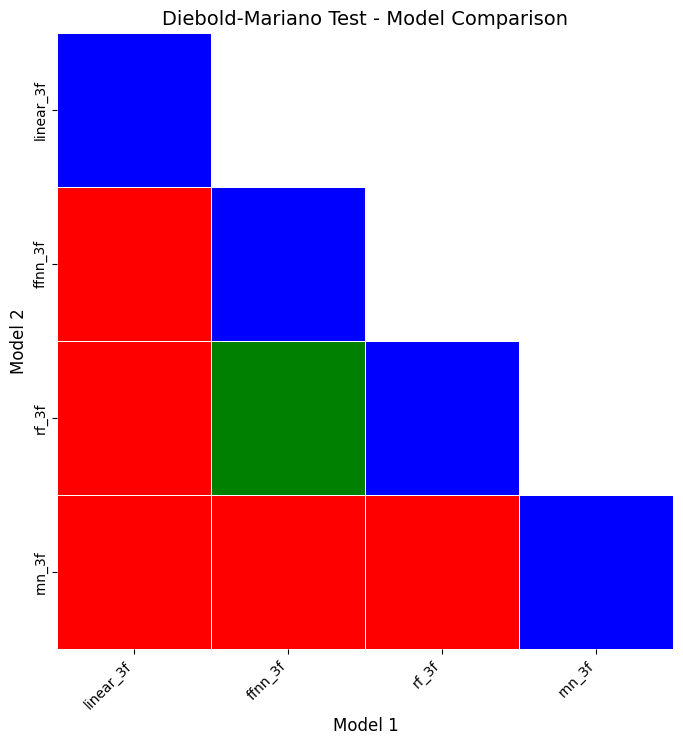

In [29]:
# Run the DM test
outcome_var = 'rolling_alpha_3f'
forecast_vars = ['linear_3f', 
                 'ffnn_3f',
                 'rf_3f',
                 'rnn_3f']

dm_stat_df, dm_pvalue_df = generate_dm_test_matrix(all_3f_alpha, outcome_var, forecast_vars)

print("DM Test Statistics:")
print(dm_stat_df)
print("\nDM Test P-values:")
print(dm_pvalue_df)

# Plot the results
plot_dm_test_results(dm_pvalue_df, title="Diebold-Mariano Test - Model Comparison")

**DM Test for 4-Factor Models**

DM Test Statistics:
          linear_4f   ffnn_4f     rf_4f    rnn_4f
linear_4f         0 -5.373616 -4.355856 -14.89979
ffnn_4f    5.373616         0  0.456596 -2.904497
rf_4f      4.355856 -0.456596         0 -3.449736
rnn_4f     14.89979  2.904497  3.449736         0

DM Test P-values:
          linear_4f ffnn_4f rf_4f rnn_4f
linear_4f         0       1     1      1
ffnn_4f          -1       0     1      1
rf_4f            -1       1     0      1
rnn_4f           -1      -1    -1      0


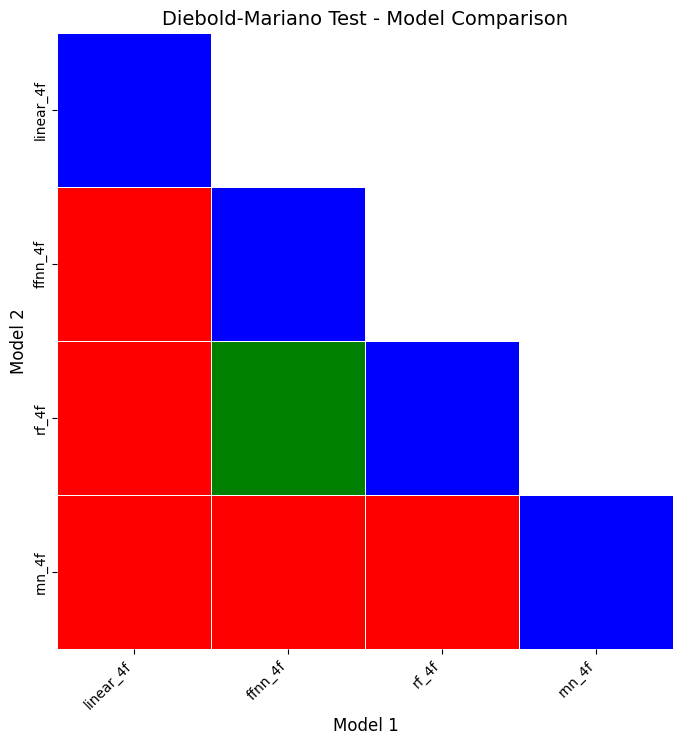

In [31]:
# **Run the DM test**
outcome_var = 'rolling_alpha_4f'
forecast_vars = ['linear_4f', 
                 'ffnn_4f',
                 'rf_4f',
                 'rnn_4f']

dm_stat_df, dm_pvalue_df = generate_dm_test_matrix(all_4f_alpha, outcome_var, forecast_vars)

print("DM Test Statistics:")
print(dm_stat_df)
print("\nDM Test P-values:")
print(dm_pvalue_df)

# Plot the results
plot_dm_test_results(dm_pvalue_df, title="Diebold-Mariano Test - Model Comparison")


**DM Test for 5 Factor Models**

DM Test Statistics:
           linear_5f    ffnn_5f     rf_5f     rnn_5f
linear_5f          0 -15.620506 -5.151605 -21.277176
ffnn_5f    15.620506          0  6.145548  -0.343854
rf_5f       5.151605  -6.145548         0  -7.530325
rnn_5f     21.277176   0.343854  7.530325          0

DM Test P-values:
          linear_5f ffnn_5f rf_5f rnn_5f
linear_5f         0       1     1      1
ffnn_5f          -1       0    -1      1
rf_5f            -1       1     0      1
rnn_5f           -1       1    -1      0


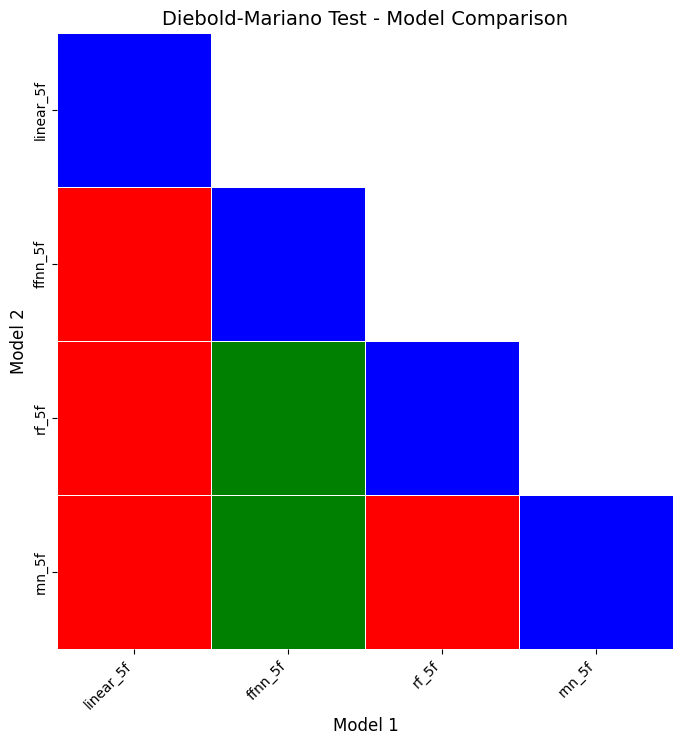

In [32]:
# Run the DM test
outcome_var = 'rolling_alpha_5f'
forecast_vars = ['linear_5f', 
                 'ffnn_5f',
                 'rf_5f',
                 'rnn_5f']

dm_stat_df, dm_pvalue_df = generate_dm_test_matrix(all_5f_alpha, outcome_var, forecast_vars)

print("DM Test Statistics:")
print(dm_stat_df)
print("\nDM Test P-values:")
print(dm_pvalue_df)

# Run and plot the results
plot_dm_test_results(dm_pvalue_df, title="Diebold-Mariano Test - Model Comparison")
